Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Grouper

In [2]:
#load json file into a pandas df
logins = pd.read_json('logins.json')

In [3]:
#check out the df: looks like we have just one column 'login_time'
logins.head() 

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#get info on df: there are 93142 entries, none are null, and all values are datetime[ns] objects
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe(datetime_is_numeric=False)

/var/folders/f3/x3f7tys571xbbpmnr9jwdnpr0000gn/T/ipykernel_35443/1846709858.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  logins.describe(datetime_is_numeric=False)


,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


We can see from the summary that not all datetime values are unique--the largest amount of non-unique dt logins is 3. However, we have no way to tell if these log ins are from different users at exactly the same time, or are true duplicates that should be removed. Going to leave them in for now.

We also see the time series begins on 01-01-1970 and ends on 04-13-1970, so it's about 4 and half months-worth of login data.

Now let's get this df ready to aggregate by 15 minute windows. I'm going to add a column to hold one count for each login, then aggregate the resulting df by 15 minute intervals to get the sum of logins for each timeframe.

In [24]:
#add a count column to aggregate
logins['count']=1

#use pandas' Grouper function to make quick work of defining the 15 minute time window and aggregate the counts for each.
q_hourly = pd.DataFrame(logins.groupby([Grouper(key='login_time', freq='15Min')]).sum())

#rename "count" column to "logins"
q_hourly.rename(columns={'count':'logins'}, inplace=True)

#make login_time column the index, to later convery to array for time series analysis
#q_hourly.reset_index()
#check our work:

q_hourly.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


looks good, we can see the aggregation began at the first login time. lets get a sum of counts to make sure all the original logins are still accounted for:

In [8]:
q_hourly['count'].sum() == len(logins)

True

Now let's begin our visualization:

In [33]:
#create a series, y, to hold the counts of use logins at each time
from statistics import mean


y = q_hourly['logins']

#get descriptive characteristics of y
print(y.describe())

print('the number of 15-minute intervals is: {}'.format(y.count()))
print('the maximum number of logins in a single interval is: {}'.format(y.max()))
print('the minimum number of logins in a single interval is: {}'.format(y.min()))
print('the mean number of logins in a single interval is: {}'.format(round(y.mean(),2)))

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: logins, dtype: float64
the number of 15-minute intervals is: 9788
the maximum number of logins in a single interval is: 73
the minimum number of logins in a single interval is: 0
the mean number of logins in a single interval is: 9.52


<AxesSubplot:xlabel='login_time'>

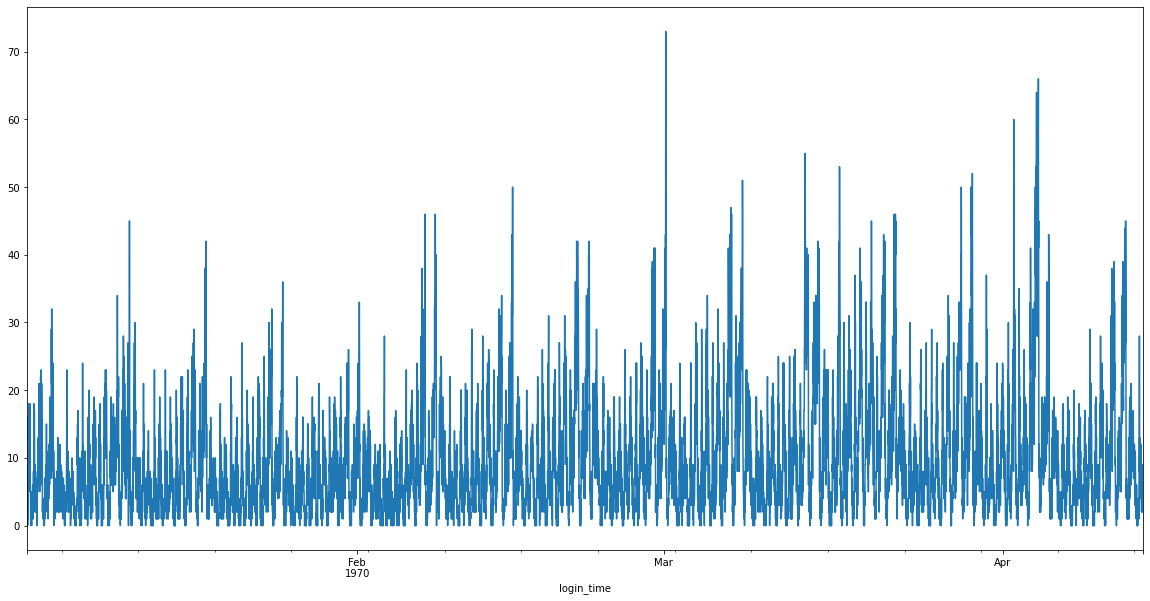

In [36]:
#plot overall time series
y.plot(figsize=(20,10))

In [39]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose


# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = seasonal_decompose(y)

#make 3 variables to hold the series data for each plot
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, tight_layout=True, figsize=(10,5))
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residuals, label = 'Residuals')
plt.legend(loc = 'best')
plt.show()


ValueError: freq T not understood. Please report if you think this is in error.